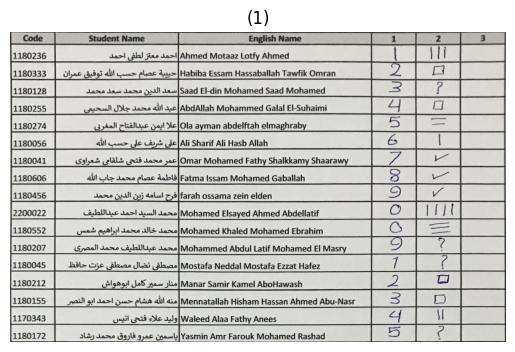

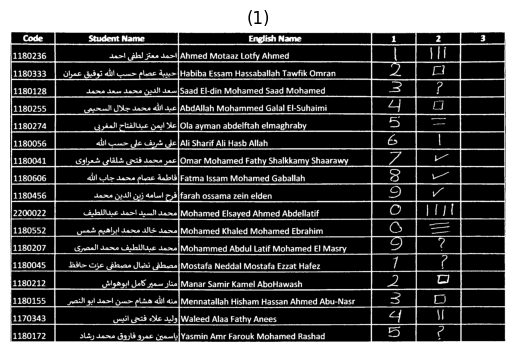

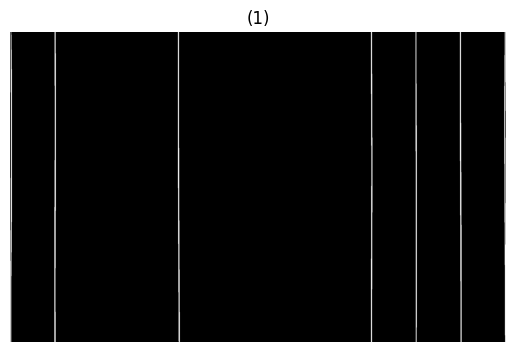

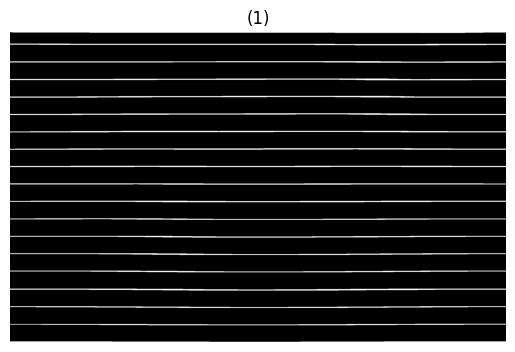

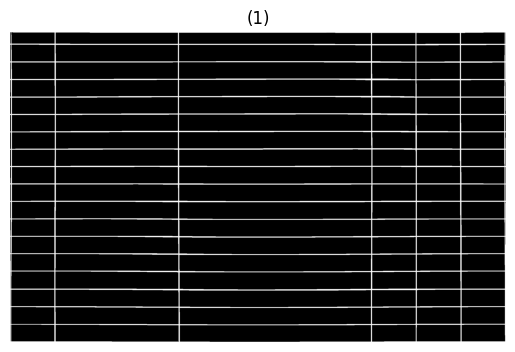

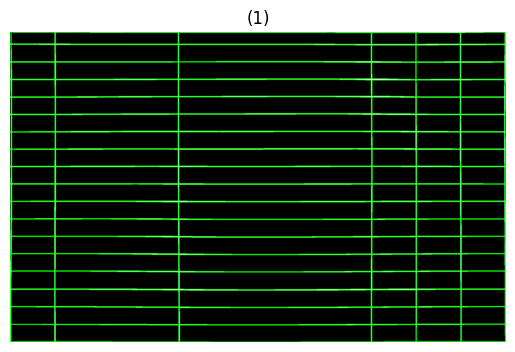

Row 1: 7 cells
    Cell 1: x=0, y=0, w=2292, h=1433
    Cell 2: x=5, y=5, w=202, h=54
    Cell 3: x=210, y=6, w=567, h=54
    Cell 4: x=780, y=7, w=889, h=54
    Cell 5: x=1672, y=8, w=203, h=53
    Cell 6: x=1877, y=8, w=203, h=53
    Cell 7: x=2083, y=6, w=204, h=54
Row 2: 6 cells
    Cell 1: x=6, y=62, w=201, h=79
    Cell 2: x=210, y=63, w=567, h=78
    Cell 3: x=780, y=63, w=889, h=78
    Cell 4: x=1672, y=65, w=203, h=77
    Cell 5: x=1877, y=64, w=203, h=78
    Cell 6: x=2083, y=63, w=204, h=78
Row 3: 6 cells
    Cell 1: x=7, y=144, w=200, h=78
    Cell 2: x=211, y=143, w=566, h=79
    Cell 3: x=780, y=143, w=889, h=78
    Cell 4: x=1672, y=145, w=203, h=78
    Cell 5: x=1877, y=145, w=203, h=78
    Cell 6: x=2083, y=144, w=203, h=78
Row 4: 6 cells
    Cell 1: x=8, y=225, w=200, h=78
    Cell 2: x=211, y=224, w=566, h=79
    Cell 3: x=780, y=223, w=890, h=78
    Cell 4: x=1673, y=226, w=202, h=77
    Cell 5: x=1877, y=226, w=203, h=77
    Cell 6: x=2083, y=225, w=203, h=78
Row 5

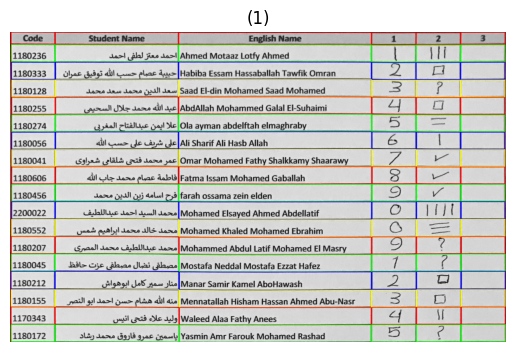

In [3]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from utils import *
from paperExtraction import *

images = ["../data/1.jpg", "../data/2.jpg", "../data/3.jpg", "../data/4.jpg", "../data/5.jpg", "../data/6.jpg", "../data/7.jpg", "../data/8.jpg", "../data/9.jpg",
               "../data/10.jpg", "../data/11.jpg", "../data/12.jpg", "../data/13.jpg", "../data/14.jpg", "../data/15.jpg", "../data/16.jpg", "../data/17.jpg",
                "../data/18.jpg", "../data/19.jpg", "../data/20.jpg", "../data/21.jpg", "../data/22.jpg","../data/23.jpg", "../data/24.jpg"]

# papers = []
# for imagePath in images:
#     paper = extractPaper(imagePath)
#     papers.append(paper)

# Example: extract rows and columns from the first paper
image = extractPaper(images[0])  # choose the paper you want to process
show_images([image])

grayScale = convertToGrayScale(image)
_, binary = cv.threshold(grayScale, 127, 255, cv.THRESH_BINARY_INV)
show_images([binary])

verticalSE = cv.getStructuringElement(cv.MORPH_RECT, (1, 20))
erodedImage = cv.erode(binary, verticalSE, iterations = 10)
verticalLines = cv.dilate(erodedImage, verticalSE, iterations = 15)

show_images([verticalLines])

horizontalSE = cv.getStructuringElement(cv.MORPH_RECT, (20, 1))
erodedImage = cv.erode(binary, horizontalSE, iterations = 10)
horizontalLines = cv.dilate(erodedImage, horizontalSE, iterations = 20)

show_images([horizontalLines])

# Added vertical and Horizontal to make table lines
verticalHorizontalLines = cv.add(verticalLines, horizontalLines)
show_images([verticalHorizontalLines])

# Make sure the image is binary before finding contours
_, tableMask = cv.threshold(
    verticalHorizontalLines, 127, 255, cv.THRESH_BINARY
)

# Find contours (table + cells)
contours, hierarchy = cv.findContours(
    tableMask,
    cv.RETR_TREE,
    cv.CHAIN_APPROX_SIMPLE
)

# Convert to color so we can draw colored contours
contoursImage = cv.cvtColor(tableMask, cv.COLOR_GRAY2BGR)

# Draw all contours
cv.drawContours(contoursImage, contours, -1, (0, 255, 0), 2)

# Show result
show_images([contoursImage])

cells = []
for contour in contours:
    x, y, w, h = cv.boundingRect(contour)
    if w > 30 and h > 20:  # threshold for valid cells
        cells.append((x, y, w, h))

# Sort contours by Y position (top → bottom)
cells = sorted(cells, key=lambda b: b[1])

# Group cells into rows
rows = []
row = [cells[0]]

for i in range(1, len(cells)):
    if abs(cells[i][1] - row[-1][1]) < 20:  # tolerance to consider same row
        row.append(cells[i])
    else:
        rows.append(sorted(row, key=lambda b: b[0]))  # sort row by X (left → right)
        row = [cells[i]]

rows.append(sorted(row, key=lambda b: b[0]))  # add last row

# Print detected rows and cells
for i, r in enumerate(rows):
    print(f"Row {i+1}: {len(r)} cells")
    for j, (x, y, w, h) in enumerate(r):
        print(f"    Cell {j+1}: x={x}, y={y}, w={w}, h={h}")

# Optional: visualize rows with colored rectangles
rowImage = cv.cvtColor(grayScale, cv.COLOR_GRAY2BGR)
colors = [(255,0,0),(0,255,0),(0,0,255),(255,255,0)]

for i, r in enumerate(rows):
    for (x, y, w, h) in r:
        cv.rectangle(rowImage, (x, y), (x+w, y+h), colors[i % 4], 2)

show_images([rowImage])